# Data

The main data I will use in this project comes from YouTube which is my watch history data. It was sent by YouTube per my request in html format. Since I intend to use pandas and plotly for data visualasation purposes the first order of business will be to clean up the html data and convert it to csv format.

# Ads

The html file containing the data related to my watch history also included the ads I watche. Below I clean the data of those ads which there were about 9.5k ads among the 55k total videos I have watched.

In [4]:
from pathlib import Path
from bs4 import BeautifulSoup
import lxml

data_file = Path("Data") / "izleme geçmişi.html"

if data_file.exists():
    print(f"File found: {data_file}")
else:
    print("File not found!")

with open(data_file, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "lxml")

ads = soup.find_all(string=lambda text: text and "Google Reklamlar" in text.replace("\xa0", " ").strip())
print(f"Found {len(ads)} ads") 

for ad in ads:
    ad_div = ad.find_parent("div", class_=lambda classes: classes and "outer-cell" in classes and "mdl-cell--12-col" in classes)
    if ad_div:
        ad_div.decompose()

cleaned_data_path = Path("Data") / "addfree_data.html"
with open(cleaned_data_path, "w", encoding="utf-8") as file:
    file.write(soup.prettify())

print(f"Cleaned HTML saved to {cleaned_data_path}")

File found: Data\izleme geçmişi.html
Found 9568 ads
Cleaned HTML saved to Data\addfree_data.html


# Community Posts

Next step of cleaning the view history data provided by YouTube is to remove the viewed community posts records as they might inflate the data regarding my usage.

In [5]:
from pathlib import Path
from bs4 import BeautifulSoup
import lxml

data_file = Path("Data") / "addfree_data.html"

with open(data_file, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "lxml") 

posts = soup.find_all(string=lambda text: text and "yayını görüntülendi" in text)

print(f"Found {len(posts)} community post records.")  

for post in posts:
    post_div = post.find_parent("div", class_=lambda classes: classes and "outer-cell" in classes and "mdl-cell--12-col" in classes)
    if post_div:
        post_div.decompose()

cleaned_file_path = Path("Data") / "ncp_nadd_data.html"
with open(cleaned_file_path, "w", encoding="utf-8") as file:
    file.write(soup.prettify())

print(f"Cleaned HTML saved to {cleaned_file_path}")


Found 1252 community post records.
Cleaned HTML saved to Data\ncp_nadd_data.html


# Conversion to CSV

Now that we have a relatively clean data at hand, I converted the html file to csv to be able to utilize pandas and plotly for data visualazation.

In [5]:
from pathlib import Path
from bs4 import BeautifulSoup
import csv
import re

data_file = Path("Data") / "ncp_nadd_data.html"
csv_file = Path("Data") / "watch_data.csv"

with open(data_file, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "lxml")

data = []

entries = soup.find_all("div", class_="outer-cell mdl-cell mdl-cell--12-col mdl-shadow--2dp")

for entry in entries:
    video_name_tag = entry.find("a", href=True)
    video_name = video_name_tag.text.strip() if video_name_tag else "Unknown"
    video_url = video_name_tag['href'].strip() if video_name_tag else "No URL"

    channel_tag = entry.find_all("a", href=True)
    channel_name = channel_tag[1].text.strip() if len(channel_tag) > 1 else "Unknown"

    watch_date_match = re.search(r"(\d{1,2} \w+ \d{4})", entry.text)
    watch_hour_match = re.search(r"(\d{2}:\d{2}:\d{2})", entry.text)
    watch_date = watch_date_match.group(1) if watch_date_match else "Unknown"
    watch_hour = watch_hour_match.group(1) if watch_hour_match else "Unknown"

    data.append([video_name, video_url, channel_name, watch_date, watch_hour])

with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Video Name", "Video URL", "Channel Name", "Watch Date", "Watch Hour"])
    writer.writerows(data)

print(f"Data successfully saved to {csv_file}")


Data successfully saved to Data\watch_data.csv


# Turkish Month Names Problem

Since the location of my YouTube account was set to Turkey in the data they provided me with month names were in Turkish. So in order for pandas functions to work properly I had to change them to English.

In [2]:
import pandas as pd

input_file = "Data/watch_data.csv"
output_file = "Data/watch_data_eng.csv"

df = pd.read_csv(input_file)

month_map = {
    "Oca": "Jan", "Şub": "Feb", "Mar": "Mar", "Nis": "Apr", "May": "May", "Haz": "Jun",
    "Tem": "Jul", "Ağu": "Aug", "Eyl": "Sep", "Eki": "Oct", "Kas": "Nov", "Ara": "Dec"
}

for turkish, english in month_map.items():
    df['Watch Date'] = df['Watch Date'].str.replace(turkish, english, regex=False)

df.to_csv(output_file, index=False)

print(f"New CSV file with English month names saved to: {output_file}")


New CSV file with English month names saved to: Data/watch_data_eng.csv


# Videos Watched Over Time

YouTube provided me with about 9-10 months worth of watch history data. Below visualized the daily amount of videos watched within that time period.

In [11]:
import pandas as pd
import plotly.express as px

file_path = "Data/watch_data_eng.csv"
df = pd.read_csv(file_path)

df['Watch Date'] = df['Watch Date'].str.strip()

df['Watch Date'] = pd.to_datetime(df['Watch Date'], format='%d %b %Y', errors='coerce')

start_date = "2024-03-01"
end_date = "2024-11-25"
filtered_df = df[(df['Watch Date'] >= start_date) & (df['Watch Date'] <= end_date)]

watch_counts = filtered_df['Watch Date'].value_counts().reset_index()
watch_counts.columns = ['Watch Date', 'Videos Watched']
watch_counts = watch_counts.sort_values(by='Watch Date')

fig = px.line(watch_counts, x='Watch Date', y='Videos Watched', 
              title="Number of Videos Watched Over Time (May 2024 - Nov 2024)",
              labels={'Videos Watched': 'Videos Watched', 'Watch Date': 'Date'})

fig.show()

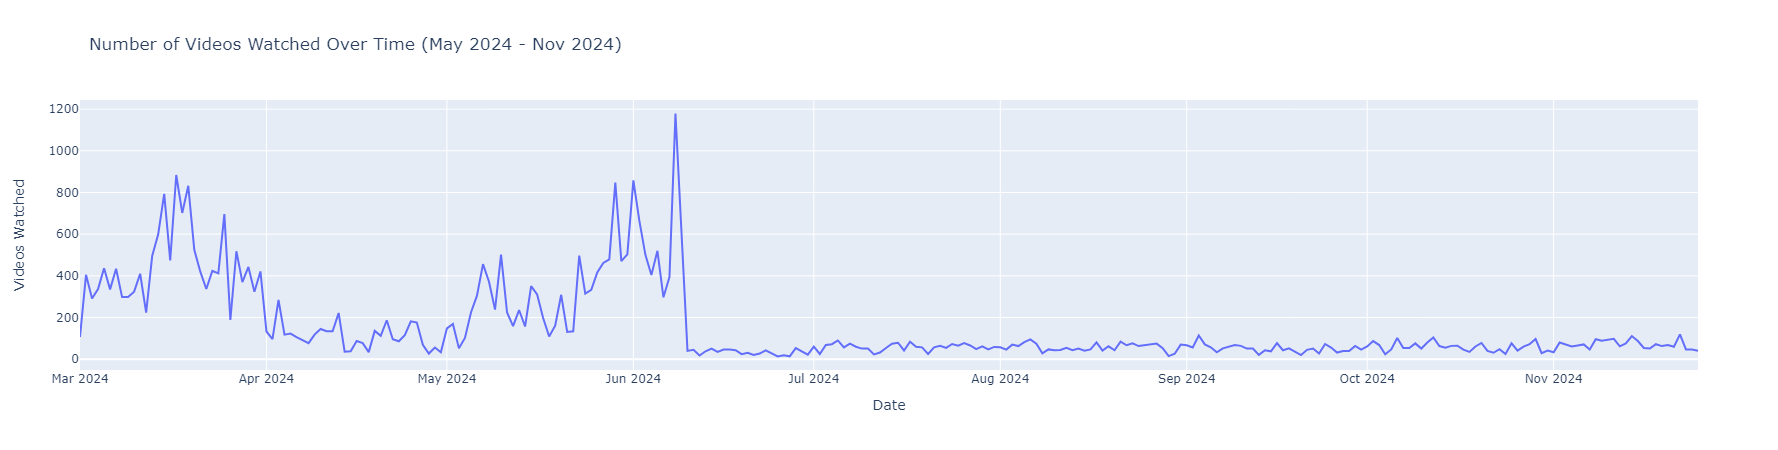

We observe here a very disportionate graph of daily video watches with a significant date being June 10th. That is the date that I stopped watching YouTube shorts which is the reason why there is such a large difference in numbers before and after. This graph also proves that was a pretty good decision since we can see my video consumption was steadily increasing untill I stopped. :)

Now unfortunately YouTube does not provide any way of differentiating a shorts video from a regular one in its dataset nor any information about video duration or watch length. So I created another graph that starts from the day I stopped watching YouTube shorts.

In [3]:
import pandas as pd
import plotly.express as px

file_path = "Data/watch_data_eng.csv"
df = pd.read_csv(file_path)

df['Watch Date'] = df['Watch Date'].str.strip()

df['Watch Date'] = pd.to_datetime(df['Watch Date'], format='%d %b %Y', errors='coerce')

start_date = "2024-06-10"
filtered_df = df[df['Watch Date'] >= start_date]

watch_counts = filtered_df['Watch Date'].value_counts().reset_index()
watch_counts.columns = ['Watch Date', 'Videos Watched']
watch_counts = watch_counts.sort_values(by='Watch Date')

fig = px.line(watch_counts, x='Watch Date', y='Videos Watched', 
              title="Number of Videos Watched Over Time (Starting June 10th, 2024)",
              labels={'Videos Watched': 'Videos Watched', 'Watch Date': 'Date'})

fig.show()


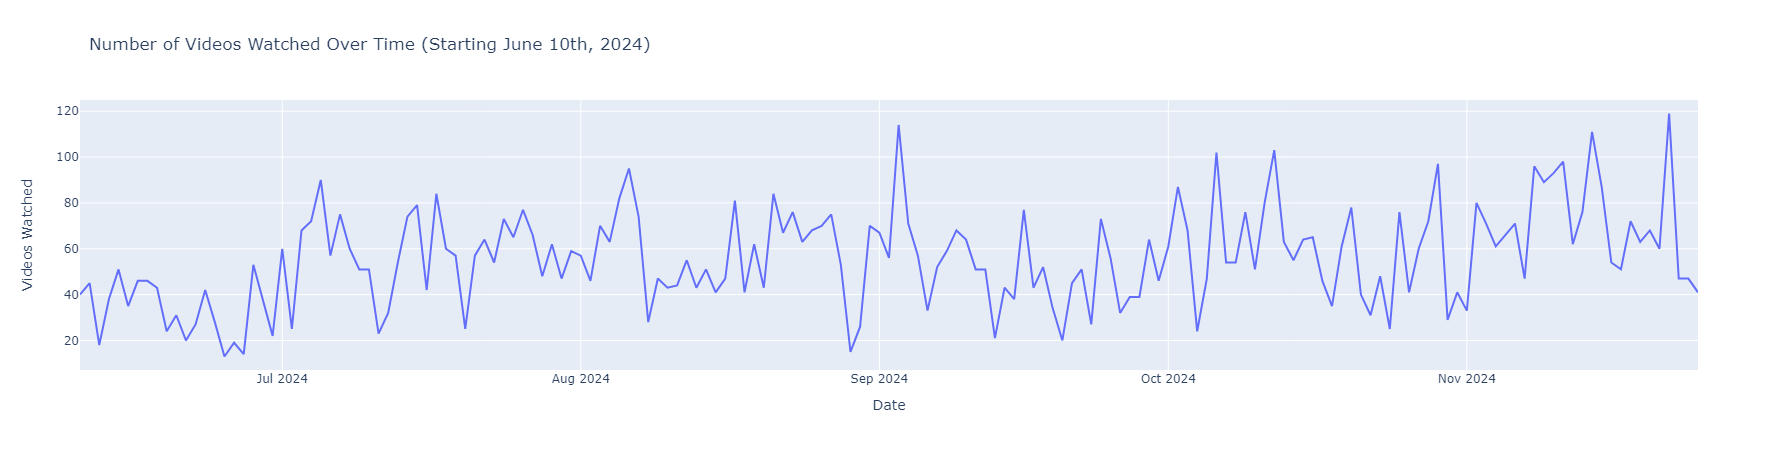

Lastly since the graph we ended up with seemed very volatile and hard to read I decided to recrate it as a scatter plot with a regression trend line to get a better overall estimation. This showed that there was a small increase in my daily video consumption overtime.

In [1]:
import pandas as pd
import plotly.express as px

file_path = "Data/watch_data_eng.csv"
df = pd.read_csv(file_path)

df['Watch Date'] = df['Watch Date'].str.strip()
df['Watch Date'] = pd.to_datetime(df['Watch Date'], format='%d %b %Y', errors='coerce')

start_date = "2024-06-10"
filtered_df = df[df['Watch Date'] >= start_date]

watch_counts = filtered_df['Watch Date'].value_counts().reset_index()
watch_counts.columns = ['Watch Date', 'Videos Watched']
watch_counts = watch_counts.sort_values(by='Watch Date')

fig = px.scatter(watch_counts, x='Watch Date', y='Videos Watched', 
                 title="Number of Videos Watched Over Time (With Regression Trend Line)",
                 labels={'Videos Watched': 'Videos Watched', 'Watch Date': 'Date'},
                 trendline="ols", 
                 trendline_color_override="red")

fig.show()


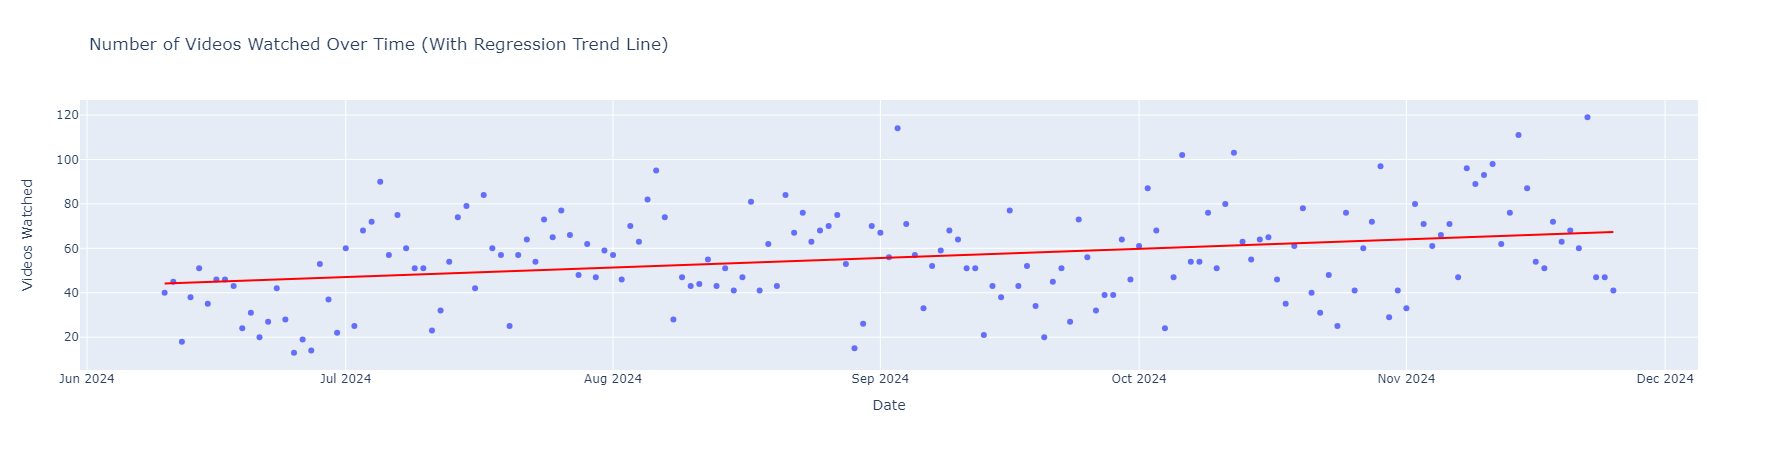

# Videos Watched by Day of the Week

Below I constructed two vertical bar charts showing the total amount of videos I have watched corresponding to the day of the week. Since the values are not too far apart from each other I have also made a log-scaled version of the graph for comparison. While the values are not too different it does show an increase in weekends and a decrease in days where my school schedule is the busiest (Thursday and Tuesday).

In [11]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


file_path = "Data/watch_data_eng.csv"
df = pd.read_csv(file_path)


df['Watch Date'] = pd.to_datetime(df['Watch Date'], format='%d %b %Y', errors='coerce')
df['Day of Week'] = df['Watch Date'].dt.day_name()


day_counts = df['Day of Week'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).reset_index()
day_counts.columns = ['Day of Week', 'Videos Watched']


fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Linear Scale", "Logarithmic Scale"],
    shared_yaxes=True  
)


fig.add_trace(
    go.Bar(
        x=day_counts['Videos Watched'],
        y=day_counts['Day of Week'],
        orientation='h',
        marker=dict(color=day_counts['Videos Watched'], colorscale='Viridis'),
        text=day_counts['Videos Watched'],
        textposition='outside',
        name="Linear Scale"
    ),
    row=1, col=1
)


fig.add_trace(
    go.Bar(
        x=day_counts['Videos Watched'],
        y=day_counts['Day of Week'],
        orientation='h',
        marker=dict(color=day_counts['Videos Watched'], colorscale='Viridis'),
        text=day_counts['Videos Watched'],
        textposition='outside',
        name="Logarithmic Scale"
    ),
    row=1, col=2
)


fig.update_layout(
    title="Distribution of Videos Watched by Day of the Week",
    height=500, width=1750,
    margin=dict(l=50, r=50, t=50, b=50),
    xaxis1=dict(title="Videos Watched (Linear Scale)"),
    xaxis2=dict(title="Videos Watched (Logarithmic Scale)", type="log"),
    yaxis=dict(title="Day of Week")  
)


fig.show()


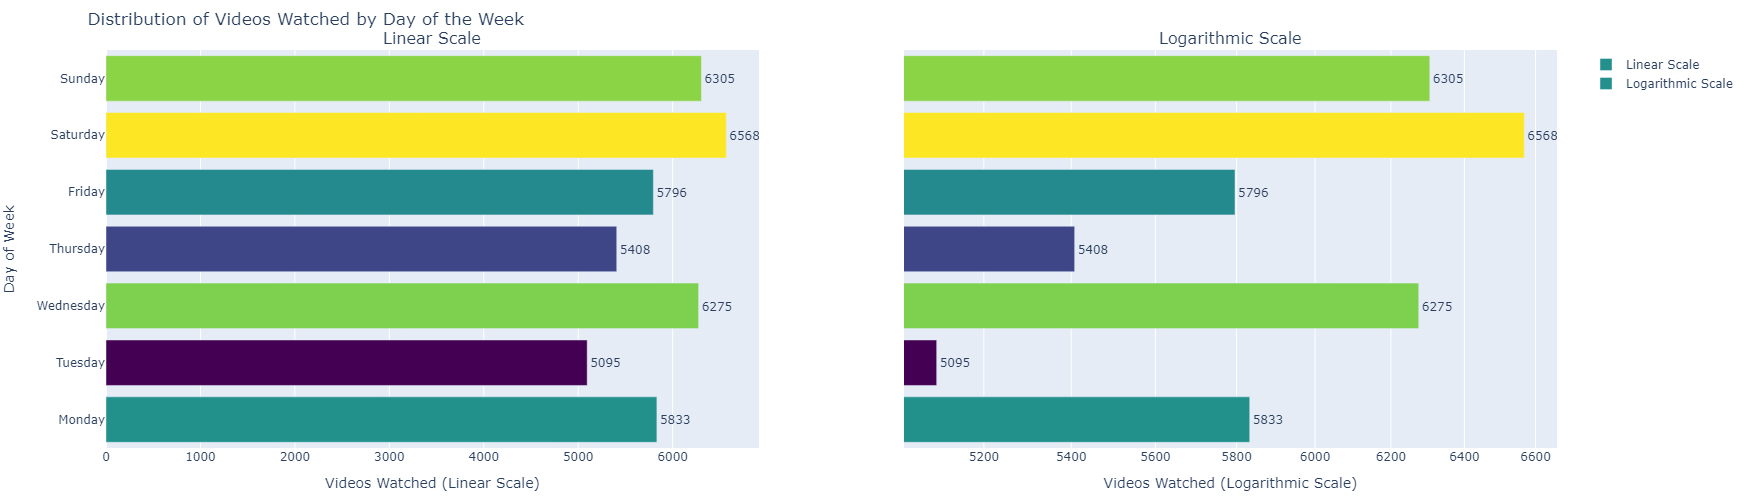

# Distribution of Videos Watched by Hour of the Day

Constructed a histogram that maps out the total videos watched by the hour.

In [14]:
file_path = "Data/watch_data_eng.csv"
df = pd.read_csv(file_path)


df['Watch Hour'] = pd.to_datetime(df['Watch Hour'], format='%H:%M:%S', errors='coerce').dt.hour


fig = px.histogram(df, x='Watch Hour',
                   title="Distribution of Videos Watched by Hour of the Day",
                   labels={'Watch Hour': 'Hour of Day', 'count': 'Number of Videos Watched'},
                   nbins=24, color_discrete_sequence=['#2A9D8F'])  


fig.update_layout(xaxis=dict(tickmode='linear', dtick=1), yaxis_title="Videos Watched")
fig.show()


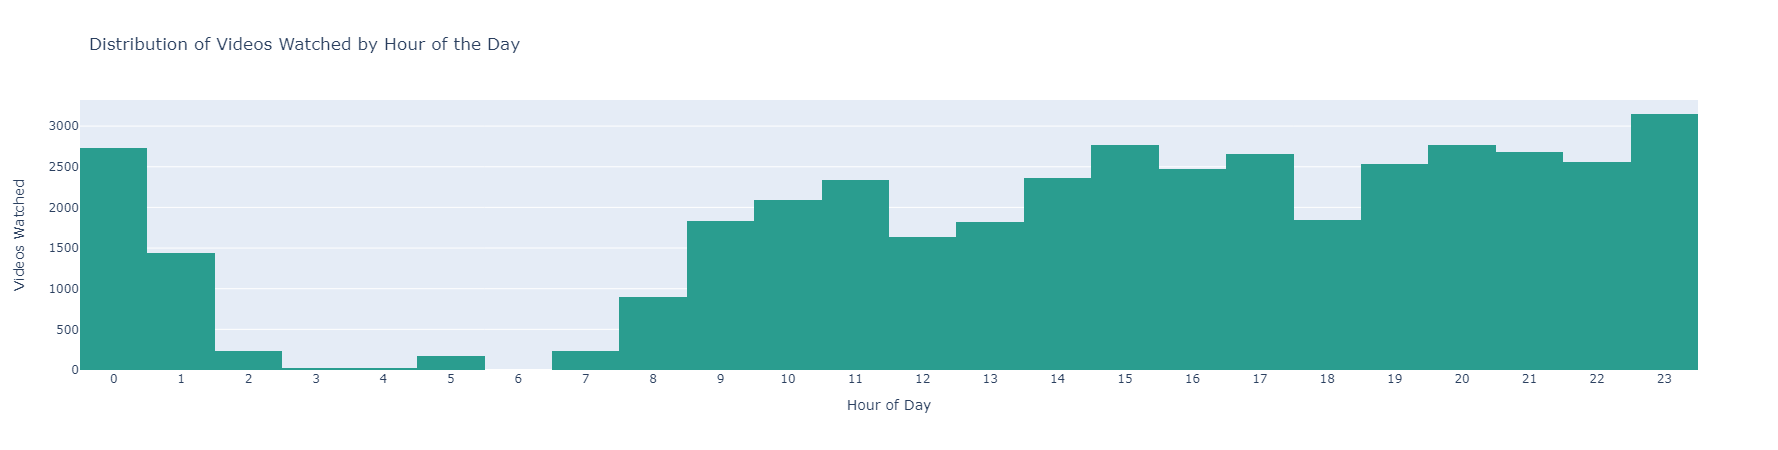

# Heat Map

Finally I constructed a heat map that combines the two above graphs and highlights the trends present.

In [12]:
import pandas as pd
import plotly.express as px


file_path = "Data/watch_data_eng.csv"
df = pd.read_csv(file_path)


df['Watch Date'] = pd.to_datetime(df['Watch Date'], format='%d %b %Y', errors='coerce')
df['Watch Hour'] = pd.to_datetime(df['Watch Hour'], format='%H:%M:%S', errors='coerce').dt.hour


df['Day of Week'] = df['Watch Date'].dt.day_name()


heatmap_data = df.pivot_table(index='Day of Week', columns='Watch Hour', aggfunc='size', fill_value=0)


ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)


fig = px.imshow(heatmap_data,
                labels=dict(x="Hour of Day", y="Day of Week", color="Videos Watched"),
                title="Heatmap of Videos Watched by Day of Week and Hour",
                color_continuous_scale="Viridis")  


fig.show()


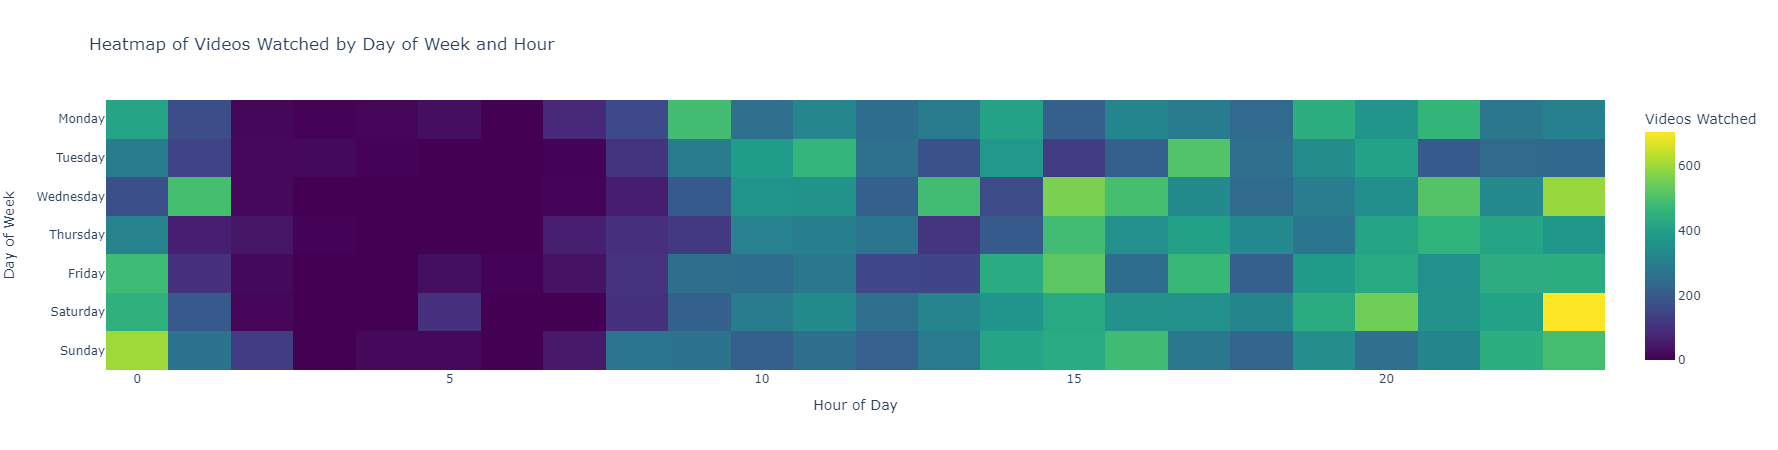

# Averages

Here I wanted to consturct a graph that showed and compared my weekly and daily averages in each month. The effect of me quitting YouTube shorts are also visible here. One thing of note is that since the monthly totals are so much larger than the averages they were causing the graph to be quite unreadable so I log scaled them.

In [12]:
import pandas as pd
import plotly.graph_objects as go


file_path = "Data/watch_data_eng.csv"
df = pd.read_csv(file_path)


df['Watch Date'] = pd.to_datetime(df['Watch Date'], format='%d %b %Y', errors='coerce')
df = df.dropna(subset=['Watch Date'])


df['Month-Year'] = df['Watch Date'].dt.strftime('%B %Y')

df['Month'] = df['Watch Date'].dt.month
df['Year'] = df['Watch Date'].dt.year


def safe_avg(count, date_range, factor):
    if date_range.days > 0:
        return count / date_range.days * factor
    else:
        return count


monthly_data = df.groupby(['Year', 'Month', 'Month-Year']).agg(
    Total_Videos=('Watch Date', 'count'),
    Weekly_Avg=('Watch Date', lambda x: safe_avg(len(x), x.max() - x.min(), 7)),
    Daily_Avg=('Watch Date', lambda x: safe_avg(len(x), x.max() - x.min(), 1))
).reset_index()


monthly_data = monthly_data.sort_values(['Year', 'Month'])


fig = go.Figure()


fig.add_trace(go.Bar(
    x=monthly_data['Month-Year'],
    y=monthly_data['Total_Videos'],
    name='Total Videos',
    marker=dict(color='rgb(31, 119, 180)'),  
    text=monthly_data['Total_Videos'],
    textposition='auto'
))


fig.add_trace(go.Scatter(
    x=monthly_data['Month-Year'],
    y=monthly_data['Weekly_Avg'],
    mode='markers+text',
    name='Weekly Average',
    text=[f"{val:.2f}" for val in monthly_data['Weekly_Avg']],
    textposition='bottom center',
    marker=dict(size=12, color='rgb(255, 127, 14)', symbol='circle'),  
    textfont=dict(color='rgb(255, 127, 14)')  
))


fig.add_trace(go.Scatter(
    x=monthly_data['Month-Year'],
    y=monthly_data['Daily_Avg'],
    mode='markers+text',
    name='Daily Average',
    text=[f"{val:.2f}" for val in monthly_data['Daily_Avg']],
    textposition='top center',
    marker=dict(size=12, color='rgb(237, 21, 21)', symbol='diamond'),  
    textfont=dict(color='rgb(237, 21, 21)')  
))


fig.update_layout(
    title="Monthly Video Watching Metrics (Log-Scaled Total Views)",
    xaxis=dict(
        title="Month",
        categoryorder="array",
        categoryarray=monthly_data['Month-Year'],  
    ),
    yaxis=dict(
        title="Number of Videos (Log Scale)",
        type='log', 
        showgrid=True
    ),
    barmode='group',
    height=600,
    width=1000,
    legend=dict(
        orientation="h", 
        yanchor="bottom", y=1.02, 
        xanchor="right", x=1
    )
)

fig.show()


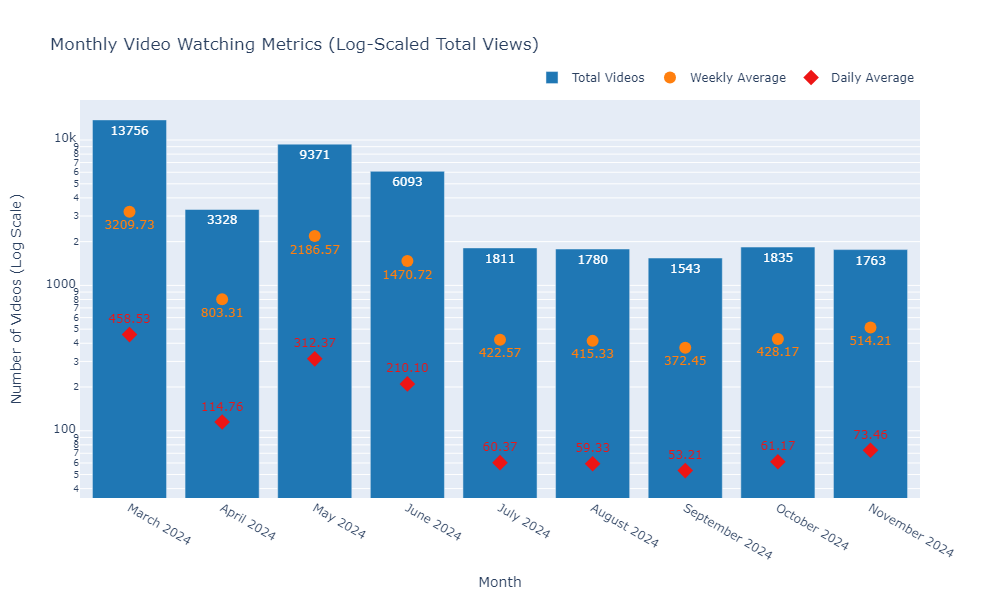

# Most Watched Channels

Constructed a bar chart to determine and showcase the channels I have viewed the most. During this processes I have encountered a problem. There were around 1.5k videos that had been removed since I have watched them. These had corrupted data and were showing up under the same channel name "buradan". So I ignored the videos with that channel name for this graph.

In [6]:
import pandas as pd
import plotly.express as px

file_path = "Data/watch_data_eng.csv"
df = pd.read_csv(file_path)

df['Channel Name'] = df['Channel Name'].str.strip()

df = df[df['Channel Name'] != "buradan"]

top_channels = df['Channel Name'].value_counts().head(10).reset_index()
top_channels.columns = ['Channel Name', 'Videos Watched']

fig = px.bar(top_channels, x='Channel Name', y='Videos Watched', 
             title="Top 10 Most-Watched Channels ",
             text='Videos Watched',
             labels={'Videos Watched': 'Number of Videos Watched', 'Channel Name': 'Channel'},
             color='Videos Watched',  
             color_continuous_scale='Viridis')  

fig.update_traces(textposition='outside')
fig.update_layout(xaxis={'categoryorder': 'total descending'}, yaxis_title='Videos Watched')

fig.show()


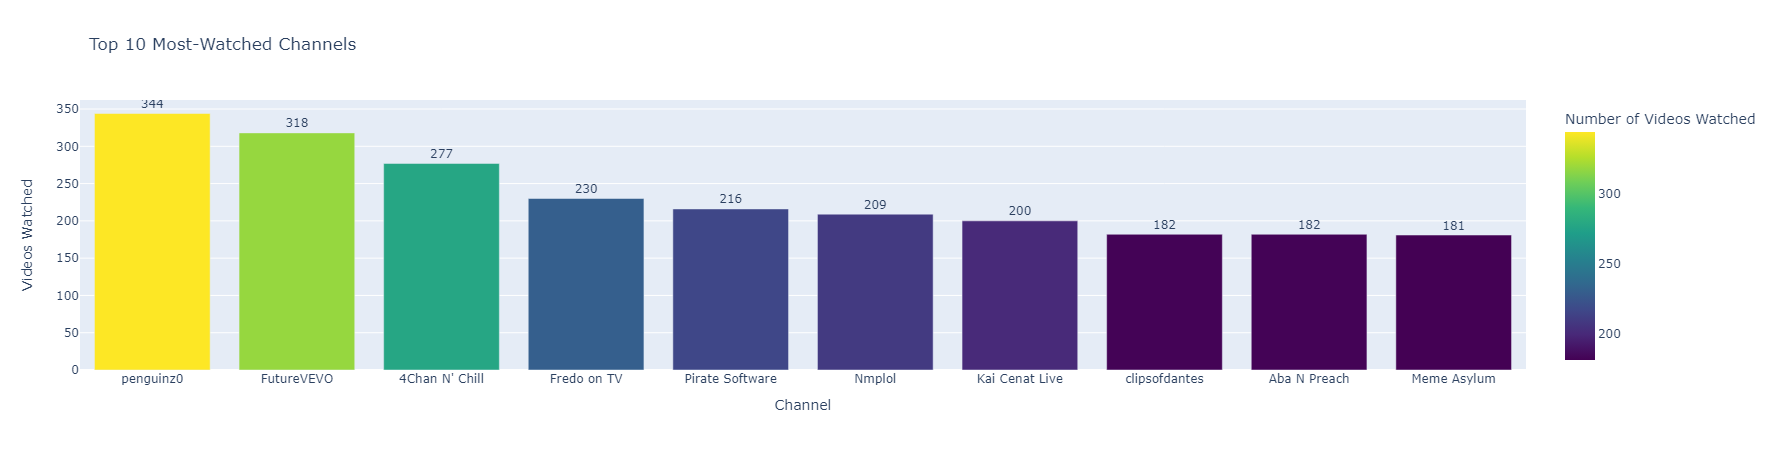

# Word Cloud 

Here I constructed a word cloud graph for the most common words in the titles of the videos I have watched. One thing of note here is that I needed to filter out some words that were muddying up the graph.

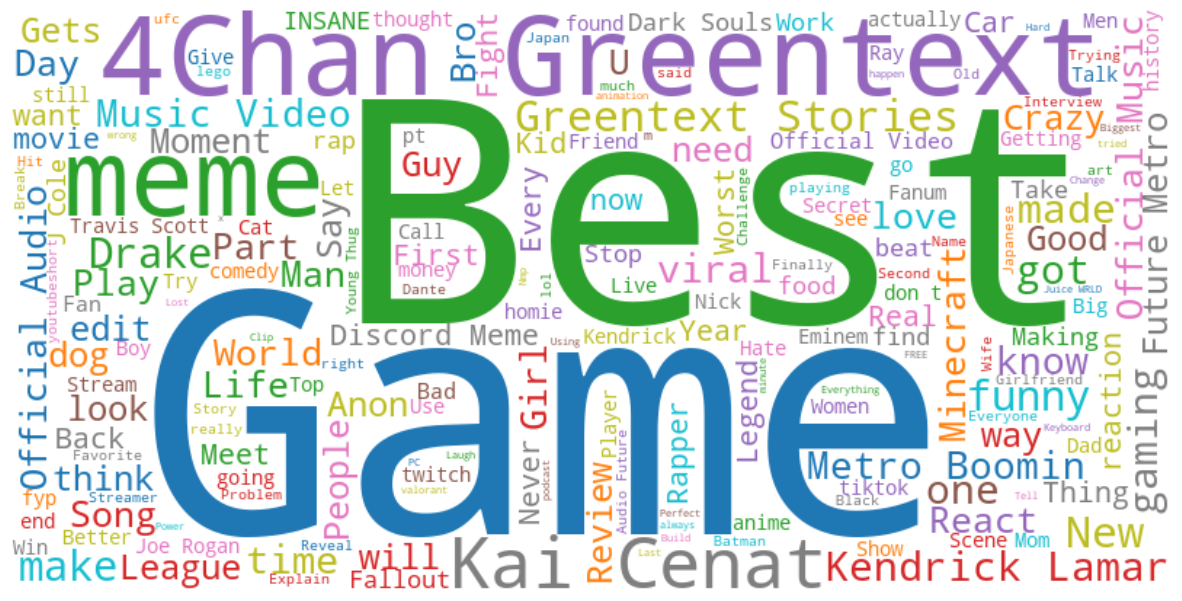

In [5]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


file_path = "Data/watch_data_eng.csv"
df = pd.read_csv(file_path)

if 'Video Name' in df.columns:
    df['Video Name'] = df['Video Name'].fillna('')  


all_titles = ' '.join(df['Video Name'])


custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['youtube', 'https', 'short', 'v', 'V', 'shorts', 'watch', 'S', 'vs'])  # Add specific words to exclude


wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white', 
    colormap='tab10',  
    stopwords=custom_stopwords
).generate(all_titles)


plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("", fontsize=16)
plt.show()

# Hyphothesis Testing

Lastly I wanted to include a hypothesis to be tested. For that I had to get another data source: The daily step count from my phone's health app. Below is a scatter plot graph comparing my daily YouTube usage to my daily step count.

Hyphothesis : There is a correlation between how physically active I am and how much YouTube content I consume on a daily basis.

Pearson Correlation Coefficient: -0.04276681261307315


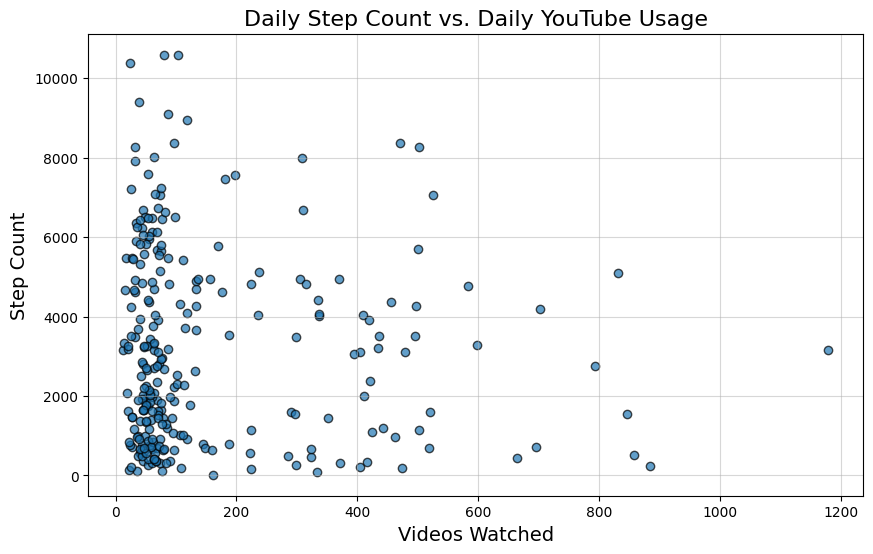

In [10]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

step_data = pd.read_csv('Data/stepcount_data.csv') 
youtube_data = pd.read_csv('Data/watch_data_eng.csv')    

step_data['date'] = pd.to_datetime(step_data['date'])

youtube_data['Watch Date'] = pd.to_datetime(youtube_data['Watch Date'], format='%d %b %Y', errors='coerce')

youtube_daily = youtube_data.groupby(youtube_data['Watch Date'].dt.date).size().reset_index(name='Videos_Watched')

youtube_daily['Watch Date'] = pd.to_datetime(youtube_daily['Watch Date'])

merged_data = pd.merge(step_data, youtube_daily, left_on='date', right_on='Watch Date', how='inner')
merged_data = merged_data.drop(columns=['Watch Date']).rename(columns={'date': 'Date', 'step_count': 'Step_Count'})

correlation, _ = stats.pearsonr(merged_data['Videos_Watched'], merged_data['Step_Count'])

print(f"Pearson Correlation Coefficient: {correlation}")

plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Videos_Watched'], merged_data['Step_Count'], alpha=0.7, edgecolor='k')
plt.title("Daily Step Count vs. Daily YouTube Usage", fontsize=16)
plt.xlabel("Videos Watched", fontsize=14)
plt.ylabel("Step Count", fontsize=14)
plt.grid(True, alpha=0.5)
plt.show()


As the scatter plot graph and a pearson coefficient of around -0.04 show my hyphothesis was not very true at all. There is little to no correlation between daily YouTube usage and how much I walk. Thus the Null Hyphothesis is rejected.